In [10]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image

import torch
import torchvision.transforms.functional as F

from utilities.data import instance_to_semantic

from config.data import DataConfig as dcfg
from config.model import ModelConfig as mcfg
from config.image import ImageStatistics

from utilities._checks import SUPPORTED_MODELS, SUPPORTED_ENCODER_BACKBONES, SUPPORTED_DECODER_BACKBONES
from utilities.preprocessing.augments import PadSingleImage


In [11]:
def prepare_model(model, checkpoint_path, device="cpu"):
    checkpoint = torch.load(checkpoint_path, map_location=device)["state_dict"]
    model.load_state_dict(checkpoint)

# Loading default values from config files.
model_type = mcfg.MODEL_TYPE
encoder_backbone_type = mcfg.ENCODER_BACKBONE
decoder_backbone_type = mcfg.DECODER_BACKBONE

# Initializing model architecture (FCN or UNet)
model = SUPPORTED_MODELS[model_type]
# Initializing model with selected encoder and decoder backbones
model = model(
    encoder_backbone=SUPPORTED_ENCODER_BACKBONES[encoder_backbone_type],
    decoder_backbone=SUPPORTED_DECODER_BACKBONES[decoder_backbone_type],
)

prepare_model(model, "checkpoints/pretrained_resnet_18/checkpoint.pth.tar")
# prepare_model(model, "/home/shaoren/Desktop/glas_qritive_submission/checkpoints/experiment/model_best.pth.tar")

In [12]:
def plot_image_and_overlay_annotation(image, annotation, alpha=0.5, show_axis=True, save_img_path=None):
    cmap = colors.ListedColormap(['lime'])

    # Ensuring that values under 1 (background) are transparent
    masked = np.ma.masked_where(annotation == 0, annotation)

    plt.imshow(image)
    plt.imshow(masked, cmap=cmap, alpha=alpha)
    if not show_axis:
        plt.axis('off')
        plt.margins(x=0)
        plt.tight_layout(pad=0)
    if save_img_path is not None:
        if not isinstance(save_img_path, str):
            raise ValueError("Output path is not a string.")
        plt.savefig(
            save_img_path, 
            bbox_inches='tight', 
            pad_inches=0,
        )
    plt.show()

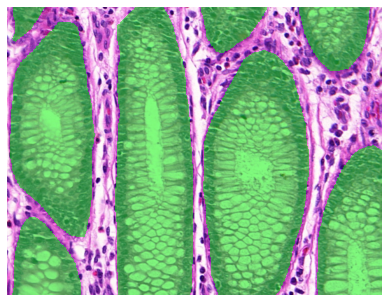

In [13]:
DATA = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/train_84.bmp"

image = Image.open(DATA)
annot = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/train_84_anno.bmp"
instance = instance_to_semantic(np.array(Image.open(annot)))

plot_image_and_overlay_annotation(image, instance, show_axis=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


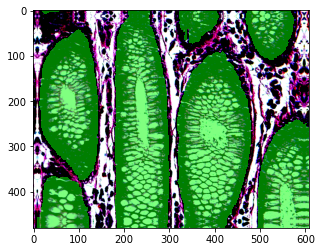

In [14]:
padding = PadSingleImage()

def get_padded_image_and_annotation_from_model(image, model):
    image = F.pil_to_tensor(image)
    padded_image = padding(image).float() / 255

    # Normalize image to match image channel statistics during training
    padded_image = F.normalize(padded_image, ImageStatistics.CHANNEL_WISE_MEANS, ImageStatistics.CHANNEL_WISE_STDS)

    with torch.no_grad():
        annotation_logits = model.segment(padded_image.unsqueeze(0))
    return padded_image.permute(1, 2, 0), np.argmax(annotation_logits, axis=1).squeeze(0)

padded_image, annotation = get_padded_image_and_annotation_from_model(image, model)

plot_image_and_overlay_annotation(padded_image, annotation)

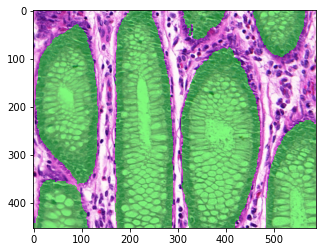

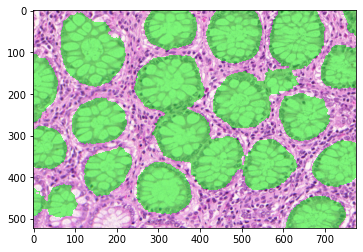

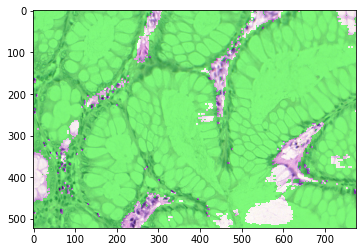

In [15]:
def return_model_predictions(image_path, model, do_crop=True):
    input_image = Image.open(image_path)

    # Make model predictions
    padded_image, padded_annotations = get_padded_image_and_annotation_from_model(input_image, model)

    # Undoing padding via cropping.
    if do_crop:
        # Keep original dimensions to undo padding via cropping
        height, width, _ = np.array(input_image).shape
        
        unpadded_image = padded_image[
            int(np.floor((padded_image.shape[0] - height) / 2)) : int(padded_image.shape[0] - np.ceil((padded_image.shape[0] - height) / 2)),
            int(np.floor((padded_image.shape[1] - width) / 2)) : int(padded_image.shape[1] - np.ceil((padded_image.shape[1] - width) / 2)),
            :
        ]

        unpadded_annotations = padded_annotations[
            int(np.floor((padded_annotations.shape[0] - height) / 2)) : int(padded_annotations.shape[0] - np.ceil((padded_annotations.shape[0] - height) / 2)),
            int(np.floor((padded_annotations.shape[1] - width) / 2)) : int(padded_annotations.shape[1] - np.ceil((padded_annotations.shape[1] - width) / 2)),
        ]

        return unpadded_image, unpadded_annotations
    else:
        return padded_image, padded_annotations

img_path = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/train_84.bmp"
image = Image.open(img_path)
annot = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/train_84_anno.bmp"
instance = instance_to_semantic(np.array(Image.open(annot)))

_, model_annotation = return_model_predictions(img_path, model)
plot_image_and_overlay_annotation(image, model_annotation)

img_path = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/testA_5.bmp"
image = Image.open(img_path)
annot = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/testA_5_anno.bmp"
instance = instance_to_semantic(np.array(Image.open(annot)))

_, model_annotation = return_model_predictions(img_path, model)
plot_image_and_overlay_annotation(image, model_annotation)

img_path = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/testA_1.bmp"
image = Image.open(img_path)
annot = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/testA_1_anno.bmp"
instance = instance_to_semantic(np.array(Image.open(annot)))

_, model_annotation = return_model_predictions(img_path, model)
plot_image_and_overlay_annotation(image, model_annotation)

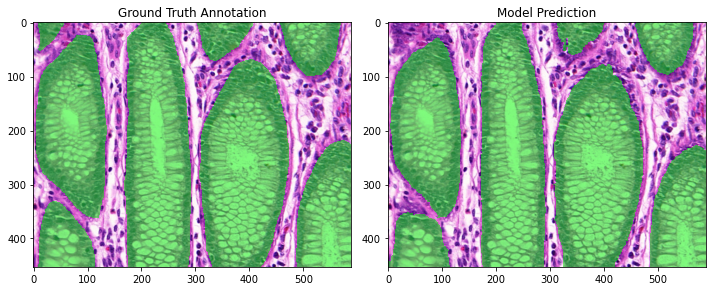

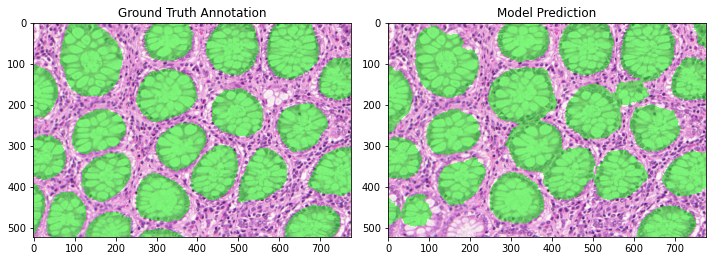

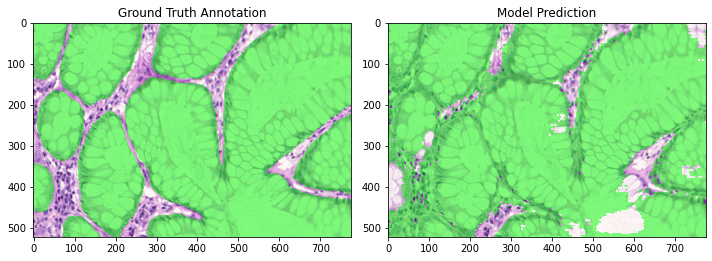

In [16]:
def compare_model_prediction_to_ground_truth(image_path, annot_path, model, do_crop=True, alpha=0.5):
    img = Image.open(image_path)

    # Get model predictions
    _, model_predictions = return_model_predictions(image_path, model, do_crop)

    ground_truth_annotation = np.array(Image.open(annot_path))

    # Masking background values of model and ground truth predictions
    masked_gt = np.ma.masked_where(ground_truth_annotation == 0, ground_truth_annotation)
    masked_pred = np.ma.masked_where(model_predictions == 0, model_predictions)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    cmap = colors.ListedColormap(['lime'])

    ax[0].set_title("Ground Truth Annotation")
    ax[0].imshow(img)
    ax[0].imshow(masked_gt, cmap=cmap, alpha=alpha)

    ax[1].set_title("Model Prediction")
    ax[1].imshow(img)
    ax[1].imshow(masked_pred, cmap=cmap, alpha=alpha)

    plt.show()


img_path = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/train_84.bmp"
annot = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/train_84_anno.bmp"
compare_model_prediction_to_ground_truth(img_path, annot, model)

img_path = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/testA_5.bmp"
annot = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/testA_5_anno.bmp"
compare_model_prediction_to_ground_truth(img_path, annot, model)

img_path = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/testA_1.bmp"
annot = "/dataset_glas/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/testA_1_anno.bmp"
compare_model_prediction_to_ground_truth(img_path, annot, model)